In [1]:
# data manipulation
import pandas as pd
import numpy as np

# plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(context='paper')

# statistics
from scipy import stats

# scrapping
import urllib.request
from bs4 import BeautifulSoup

# comparing sequences
import difflib

# regex
import re

from sqlalchemy import create_engine

In [2]:
# import datasets
engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

## Analyse de forme

Le dataframe df_patient contient 20000 lignes et 12 colonnes ; on observe 3 types de données : objet, int64 et float64. 
Les dates de naissance sont au format AAAAMMDD. 

Le dataframe contient également des informations sur le lieu de résidence des patients, notamment l'état et le code postal. 
L'Australie est constitué de 8 états, chacun étant défini par une plage de codes postaux (source: [Wikipedia](https://en.wikipedia.org/wiki/Postcodes_in_Australia)):
- **NSW (New South Wales):** 1000 -> 1999 (LVRs and PO seulement),  2000 -> 2599, 2619 -> 2899, 2921 -> 2999.
- **ACT (Australian Capital Territory) :** 	0200 -> 0299 (LVRs and PO seulement), 2600 -> 2618, 2900 -> 2920.
- **VIC (Victoria) :** 3000 -> 3999, 8000 -> 8999 (LVRs and PO seulement).
- **QLD (Queensland) :** 4000 -> 4999, 9000 -> 9999 (LVRs and PO seulement).
- **SA (South Australia) :** 5000 -> 5799, 5800 -> 5999 (LVRs and PO seulement).
- **WA (Western Australia) :** 	6000 -> 6797, 6800 -> 6999 (LVRs and PO seulement).
- **TAS (Tasmania) :** 7000 -> 7799, 7800 ->7999 (LVRs and PO seulement).
- **NT (Northern Territory):** 0800 -> 0899, 0900 -> 0999 (LVRs and PO seulement).

Le dataframe fournit également le nom, le prénom et l'age des patients. Ainsi qu'un numéro téléphone, qui est au format : **0X XXXXXXXX**. Il est constitué d'un code d'accès le '0' puis du code de la zone suivi du numéro local (source : [Wikipedia](https://en.m.wikipedia.org/wiki/Telephone_numbers_in_Australia)). 

- **00**: Accès international et d'urgence (voir ci-dessous les détails).
- **01**: Services téléphoniques alternatifs.
    - **014**: Téléphones satellites.
    - **0163**: Numéros de téléavertisseur.
    - **0198** Numéros de données.
- **02**: Région du Centre-Est ( NSW , ACT )
- **03**: Région du Sud-Est ( VIC , TAS )
- **04**: Services mobiles numériques ( 3G , 4G , 5G et GSM )
- **0550**: Services de communication indépendants de l'emplacement
- **07**: Géographie: région du Nord-Est ( QLD )
- **08**: Région du Centre et de l'Ouest ( SA , NT , WA )
- **1** Numéros non géographiques


### Correspondance des variables

In [3]:
# dictionnary of states
dict_state = {'nsw': 'New South Wales', 
             'act': 'Australian Capital Territory',
             'vic': 'Victoria',
             'qld': 'Queensland',
             'sa': 'South Australia',
             'wa': 'Western Australia',
             'tas': 'Tasmania',
             'nt': 'Northern Territory'}

# dictionnary of "area" zone
dict_phone_number = {'01': 'Alternative phone services',
                    '02': 'nsw act',
                    '03': 'vic tas',
                    '04': 'Digital Mobile services',
                    '07': 'qld',
                    '08': 'sa nt wa'}

In [8]:
def scrapping_wikipedia(url):
    """
    This function find the poscode range by state from wikipedia.
    
    url = 'https://en.wikipedia.org/wiki/Postcodes_in_Australia'
    """    
    # open the url using urllib.request and put the HTML into the page variable
    page = urllib.request.urlopen(url)
    
    # parse the HTML from our URL into the BeautifulSoup parse tree format
    soup = BeautifulSoup(page, "lxml")
    
    # use the 'find_all' function to bring back all instances of the 'table' tag in the HTML and store in 'all_tables' variable
    all_tables=soup.find_all("table")
    
    # find the right table
    right_table=soup.find('table', class_='wikitable')
    
    # list of elements by column
    A=[]
    B=[]
    C=[]
    
    for row in right_table.findAll('tr'): # find rows
        cells=row.findAll('td') # find data
        if len(cells)==3: # 3 is the number of columns
            #append cell value
            A.append(cells[0].find(text=True)) 
            B.append(cells[1].find(text=True).lower()) 
            C.append(cells[2].get_text(separator=' ')) 
    
    # create the dataframe from table
    df=pd.DataFrame(A,columns=['State'])
    df['Abbreviation']=B
    df['Postcode range']=C
    
    # postcode range dictionnary
    poscode_range={}
    
    # for each state find the poscode range
    for abb in df.Abbreviation.values:
        poscode_range[abb] = re.findall('[0-9]+', 
                                             df['Postcode range'][df.index[df['Abbreviation'] == abb].tolist()[0]])
    
    return poscode_range

dict_poscode_range= scrapping_wikipedia('https://en.wikipedia.org/wiki/Postcodes_in_Australia')

In [9]:
dict_poscode_range

{'nsw': ['1000', '1999', '2000', '2599', '2619', '2899', '2921', '2999'],
 'act': ['0200', '0299', '2600', '2618', '2900', '2920'],
 'vic': ['3000', '3999', '8000', '8999'],
 'qld': ['4000', '4999', '9000', '9999'],
 'sa': ['5000', '5799', '5800', '5999'],
 'wa': ['6000', '6797', '6800', '6999'],
 'tas': ['7000', '7799', '7800', '7999'],
 'nt': ['0800', '0899', '0900', '0999']}

### Forme des données

In [10]:
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [11]:
df_pcr.head()

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


In [12]:
df_pcr.shape

(8800, 2)

In [13]:
df_patient.shape

(20000, 12)

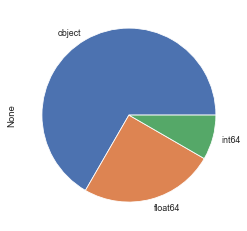

In [14]:
# check the data type of each column
df_patient.dtypes.value_counts().plot.pie()
plt.show()

## Données manquantes

On observe que la variable _**address_2**_ comprend le plus de valeurs manquantes (> 60%). Pour les autres variables, le taux de valeurs manquantes est compris entre 20 et 1%. Sauf pour la variable patient_id qui ne comporte pas de données manquantes.

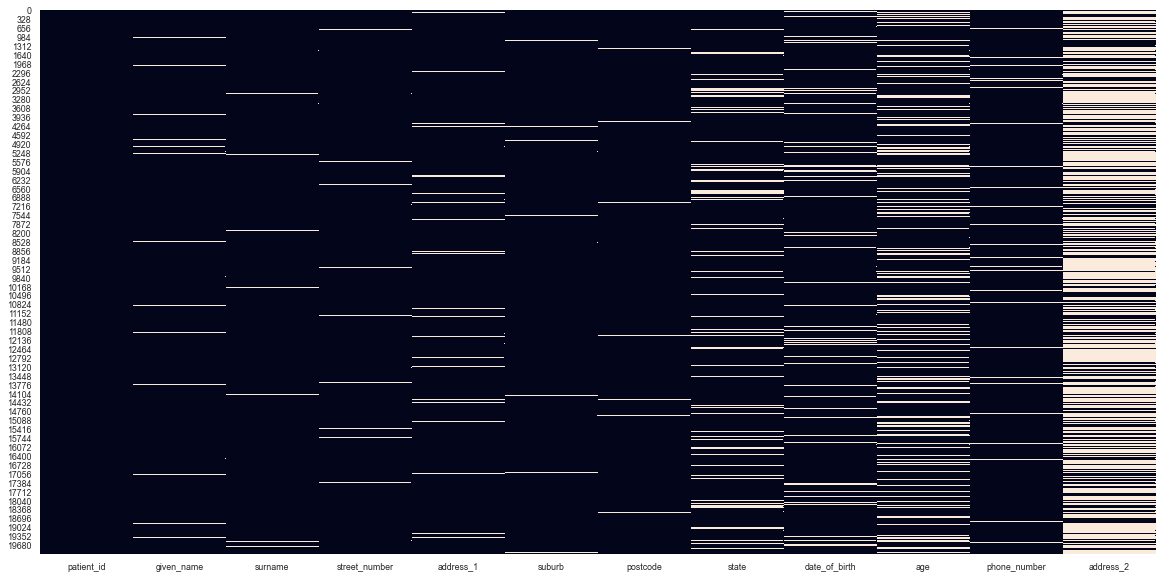

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(df_patient.isna(), cbar=False)
plt.show()

In [16]:
# Missing values
total = df_patient.isnull().sum().sort_values(ascending = False)
percent = round(total/df_patient.shape[0]*100 ,2)
pd.concat([total, percent], axis = 1, keys=["Total missing values","%"])

,Total missing values,%
address_2,12107,60.54
age,3997,19.98
date_of_birth,2011,10.06
state,1990,9.95
phone_number,919,4.60
address_1,796,3.98
given_name,440,2.20
surname,425,2.12
street_number,382,1.91
suburb,212,1.06


## Qualité des données

On observe que la variable **state** comporte plus de 8 modalités. En effet, elle compte 103 modalités. Un visualisation rapide nous permet de conclure que à des erreurs de saisie.

Pour les variables de type **'object'**, nous allons vérifier s'il existe des valeurs de type numérique. 
On observe alors que la variable **suburb**(banlieue) comporte 13 valeurs numériques. Pour la variable **postcode**(code postal), on observe l'existence de 14 valeurs textuelles.

La visualisation des lignes vérifiant ces incohérences, nous permet de conclure que les valeurs ont été interverties.

Pour le patient N° 727290, en plus de cette inversion, on constate une erreur de saisi au niveau du code postal (467l0). En effet, la lettre 'l' s'est glissée entre le 7 et le 0.

Enfin, la variable apparait comme étant constitué uniquement de valeurs textuelles. En effet, le format des valeurs (0X XXXXXXXX) ne permet pas de vérifier s'il s'agit de valeurs numériques ou textuelles. Un pré-traitement sera nécessaire si l'on souhaite utiliser cette variable.

In [17]:
df_patient_qlt = df_patient.copy()

In [18]:
# state
print(df_patient_qlt.state.unique())
print('Feature State, Number of modalities : {}'.format(len(df_patient_qlt.state.unique())))

['wa' 'nsw' 'qld' 'nt' 'sa' None 'act' 'vic' 'tas' 'vc' 'qkd' 's' 'qlh'
 'nswf' 'ndw' 'nsjw' 'nsza' 'nu' 'vicf' 'vicb' 'nswt' 'nsg' 'qlf' 'wr'
 'vicz' 'nsa' 'wab' 'qxlj' 'ai' 'qlg' 'vil' 'qln' 'qlc' 'ws' 'qls' 'viv'
 'ta' 'nswm' 'nfw' 'vie' 'nsq' 'nxw' 'nfsw' 'vkc' 'qlr' 'ns' 'naw' 'ic'
 'nwd' 'qod' 'tab' 'nsd' 'vmv' 'fsw' 'vich' 'nwx' 'a' 'qlt' 'nsc' 'wu'
 'nss' 'vucm' 'vix' 'nsy' 'ng' 'nse' 'w' 'ql' 'sv' 'taz' 'tak' 'vh' 'nze'
 'nswb' 'qlz' 'vicm' 'waw' 'nsew' 'nvq' 'wz' 'gic' 'vid' 'qldg' 'vuv'
 'vib' 'qud' 'nsxw' 'nlw' 'vif' 'nsn' 'nssw' 'nsgs' 'vicw' 'wq' 'vq'
 'nswn' 'tad' 'qle' 'vcci' 'qdd' 'vi' 'qldy' 'nsjh']
Feature State, Number of modalities : 103


In [19]:
def check_isdigit(df, feat):
    """
    This function check if a string is numeric or not
    """
    print(df[feat].str.isdigit().value_counts(), '\n')

In [20]:
# return the number of numeric value for each columns of dtypes 'object'
for feature in df_patient_qlt.dtypes[df_patient_qlt.dtypes == 'object'].index:
    check_isdigit(df_patient_qlt, feature)

False    19560
Name: given_name, dtype: int64 

False    19575
Name: surname, dtype: int64 

False    19204
Name: address_1, dtype: int64 

False    19775
True        13
Name: suburb, dtype: int64 

True     19787
False       14
Name: postcode, dtype: int64 

False    18010
Name: state, dtype: int64 

False    19081
Name: phone_number, dtype: int64 

False    7893
Name: address_2, dtype: int64 



In [21]:
# columns : suburb. dataframe of inconsistent data
df_patient_qlt[df_patient_qlt.suburb.str.isdigit() == True]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740,None
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599,None
5792,752873,lochlan,blake,258.0,None,4216,toowoobma,wa,19080821.0,31.0,02 84630666,None
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,None,19640421.0,8.0,02 69439226,None
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391,None
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,None,None
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511,None
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647,None
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,None,19660615.0,26.0,02 68667816,None
15575,572694,isabella,beddimg,17.0,heidelberg street,3764,toowoomba,nsw,19510108.0,NaN,03 01075733,laurel bank


In [22]:
# columns : postcode. dataframe of inconsistent data
df_patient_qlt[df_patient_qlt.postcode.str.isdigit() == False]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740,None
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599,None
5792,752873,lochlan,blake,258.0,None,4216,toowoobma,wa,19080821.0,31.0,02 84630666,None
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,None,19640421.0,8.0,02 69439226,None
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391,None
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,None,None
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,None,pangani
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511,None
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647,None
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,None,19660615.0,26.0,02 68667816,None


## Gestion des doublons

Le but de cette exercice étant de représenter et de discuter la prévalence de la maladie dans la population, on peut alors ignorer les individus dont le patient_id n'est pas présent dans le dataframe _**df_pcr**_.

In [23]:
df_patient_dbl = df_patient.copy()

In [24]:
# get unique patient_id in the dataframe df_pcr
df_pcr_unique = df_pcr.patient_id.unique()

# subset rows in dataframe df_patient
df_patient_dbl = df_patient_dbl[df_patient_dbl.patient_id.isin(df_pcr_unique)]

In [25]:
# Missing values
total_2 = df_patient_dbl.isnull().sum().sort_values(ascending = False)
percent_2 = round(total_2/df_patient_dbl.shape[0]*100 ,2)
dif = percent - percent_2
pd.concat([total_2, percent_2, dif], axis = 1, keys=["Total missing values","%", "Gap"])

,Total missing values,%,Gap
address_2,5371,60.36,0.18
age,1767,19.86,0.12
state,900,10.11,-0.16
date_of_birth,863,9.70,0.36
phone_number,433,4.87,-0.27
address_1,329,3.70,0.28
given_name,202,2.27,-0.07
surname,175,1.97,0.15
street_number,155,1.74,0.17
suburb,97,1.09,-0.03


In [26]:
dbl_patient_id= []
for id_patient in df_pcr_unique:
    if len(df_patient_dbl[df_patient_dbl.patient_id == id_patient]) != len(df_pcr[df_pcr.patient_id == id_patient]) :
        dbl_patient_id.append(id_patient)

In [27]:
for rows in dbl_patient_id:
    print(df_patient_dbl[df_patient_dbl.patient_id == rows])
    print(df_pcr[df_pcr.patient_id == rows])
    print(50*'-')

      patient_id given_name surname  street_number      address_1      suburb  \
2264      251094      talia  antoku            9.0  hosking place        None   
4855      251094    william   leung           72.0  masters place  cabramatta   

     postcode state  date_of_birth   age phone_number address_2  
2264     4670    sa     19341221.0  27.0  08 43580956      None  
4855     5330   nsw     19040212.0  20.0  07 31325095      None  
    patient_id pcr
45      251094   N
--------------------------------------------------
       patient_id given_name   surname  street_number           address_1  \
9419       723756     fraser    clarke           16.0       dexter street   
15591      723756      holly  grossman          119.0  fred lane crescent   

        suburb postcode state  date_of_birth   age phone_number address_2  
9419    cairns     2232   vic     19930927.0  31.0  03 46900758      None  
15591  batlogw     5169   vic     19481206.0   NaN  08 63396557      None  
    patie

      patient_id given_name surname  street_number       address_1  \
9557      264404      andie   eayrs           11.0  lowanna street   
9755      264404        max   dolan           35.0  emerton street   

            suburb postcode state  date_of_birth   age phone_number  \
9557  geelong west     5371   tas     19460803.0  36.0  08 15663427   
9755     newmarket     3085   nsw     19390306.0  20.0         None   

          address_2  
9557  dalkeith park  
9755         larook  
      patient_id pcr
1809      264404   N
--------------------------------------------------
       patient_id given_name    surname  street_number       address_1 suburb  \
12117      109304    zachary  farronato           30.0  outtrim avenue   como   
14839      109304     bailey  donaldson           20.0  tardent street   ryde   

      postcode state  date_of_birth   age phone_number  address_2  
12117     2196   vic     19090801.0  31.0  07 22894061  the reefs  
14839     0812   qld     19580310.0 

3725                       None  
      patient_id pcr
3775      645735   N
--------------------------------------------------
      patient_id given_name surname  street_number           address_1  \
6167      488227     lawson  wegman          174.0  wyselaskie circuit   
9007      488227      harry    None          167.0    tazewell circuit   

          suburb postcode state  date_of_birth   age phone_number address_2  
6167  burpengary     4224    wa     19560505.0  29.0  04 04404723     uarah  
9007    cronulla     4221   qld     19170116.0  30.0  08 45991266      None  
      patient_id pcr
3959      488227   P
--------------------------------------------------
       patient_id given_name   surname  street_number          address_1  \
11823      840126   nicholas     caire            1.0  burramurra avenue   
17145      840126       None  eglinton           12.0     helemon street   

           suburb postcode state  date_of_birth   age phone_number address_2  
11823     figtr

      patient_id       pcr
5605      436199  Negative
--------------------------------------------------
       patient_id given_name   surname  street_number          address_1  \
10336      799495    nemesia  gulliver           24.0  williamson street   
11798      799495       tori   riddoch           85.0   batchelor street   

          suburb postcode state  date_of_birth   age phone_number   address_2  
10336  woollahra     4011   qld     19901220.0  33.0  02 06040833  rowethorpe  
11798    belrose     2220  None     19390611.0  24.0  02 53302645        None  
      patient_id pcr
5673      799495   N
--------------------------------------------------
       patient_id given_name surname  street_number        address_1  \
15398      660591       rhys  ukleja          388.0  oakover circuit   
16471      660591    michael  thorpe           31.0     blythe close   

            suburb postcode state  date_of_birth   age phone_number  \
15398    bayswater     4226  None     1924080

       patient_id given_name surname  street_number         address_1  \
9374       636114      oscar    lock           68.0  gillespie street   
16293      636114     olivia   noble           29.0  callaghan street   

                 suburb postcode state  date_of_birth   age phone_number  \
9374            yagoona     4872   vic     19110529.0   NaN  03 52049847   
16293  winchelsea south     None  None     19910317.0  38.0  07 00497143   

       address_2  
9374    kippilaw  
16293  glen mere  
      patient_id       pcr
7034      636114  Negative
--------------------------------------------------
       patient_id given_name     surname  street_number             address_1  \
6053       285639    alaiyah     purtell           11.0        beeston street   
16313      285639     teegan  pettingill           81.0  may maxwell crescent   

           suburb postcode state  date_of_birth  age phone_number address_2  
6053   narrandera     2906   vic     19100825.0  NaN  04 99654513  

8372     2768   nsw     19440301.0  14.0  03 54454715      None  
      patient_id pcr
8499      732543   N
--------------------------------------------------
       patient_id given_name  surname  street_number        address_1  \
8110       935544   isabelle  bitmead           14.0       lyle place   
11096      935544       ruby  tschirn          279.0  chambers street   

          suburb postcode state  date_of_birth   age phone_number  \
8110     revesby     4883   nsw     19110421.0  28.0  03 51192413   
11096  marsfield     2612   vic     19200202.0   NaN  03 18765876   

                     address_2  
8110                      None  
11096  takalvan medical centre  
      patient_id pcr
8548      935544   P
--------------------------------------------------
       patient_id given_name surname  street_number       address_1    suburb  \
153        301664       luke    roff           63.0  torrens street  lilydale   
16267      301664      kayla    rees           12.0  dalgar

In [28]:
# return the number of numeric value for each columns of dtypes 'object'
for feature in df_patient_dbl.dtypes[df_patient_dbl.dtypes == 'object'].index:
    check_isdigit(df_patient_dbl, feature)

False    8696
Name: given_name, dtype: int64 

False    8723
Name: surname, dtype: int64 

False    8569
Name: address_1, dtype: int64 

False    8796
True        5
Name: suburb, dtype: int64 

True     8798
False       5
Name: postcode, dtype: int64 

False    7998
Name: state, dtype: int64 

False    8465
Name: phone_number, dtype: int64 

False    3527
Name: address_2, dtype: int64 



In [29]:
def state_data_cleaning(df):
    """ This function
    
    p: df - dataframe    
    """
    
    import difflib
    
    # not right state names
    dict_others_states = {}
    
    # states in the dataframe
    states = df_patient.state.value_counts().index
    
    for st in states:
        if st not in dict_state.keys():
            dict_others_states[st] = difflib.get_close_matches(st, 
                                                                  dict_state.keys(),
                                                                 cutoff=0.3)[0]
    #return dict_others_states
    if df['state'] in dict_state.keys():
        return df['state']
    elif df['state'] is None:
        return None
    else:
        return dict_others_states[df['state']]


def detect_duplicates(df):
    """
    """
    
    # get unique patient_id in the dataframe df_pcr
    df_pcr_unique = df_pcr.patient_id.unique()
    
    # subset rows in dataframe df_patient
    df_dbl = df[df.patient_id.isin(df_pcr_unique)]
    
    # add columns state cleaning
    df_dbl['state_cln'] = df_dbl.apply(state_data_cleaning, axis= 1)
    
    # add columns area zone (phone number)
    df_dbl['area_zone'] = df_dbl.phone_number.str.extract(r'([^\s]+)')
    
    # 
    df_dbl['area_zone_name'] = df_dbl.apply(zone_name, axis= 1)
    
    return df_dbl